In [1]:
import boto3
import configparser
import os
import urllib3

import folium
import geopandas as gpd
import pandas as pd
import pyarrow.parquet as pq
import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot
from shapely import wkb
import contextily as cx

import tempfile

In [2]:
urllib3.disable_warnings()

### Connection with S3 Bucket
All Census GRID datasets are available on S3 Bucket. Below configuration allows to list and download defined datasets from there.

In [3]:
def s3_connection(credentials: dict) -> boto3.session.Session:
    """Establishes a connection to an S3 bucket.

    Args:
        credentials (dict): A dictionary containing AWS S3 credentials with keys 
                            'host_base', 'access_key', and 'secret_key'.

    Returns:
        boto3.session.Session: A boto3 session client configured with the provided 
                               credentials for interacting with the S3 service.
    """
    s3 = boto3.client('s3',
                      endpoint_url=credentials['host_base'],
                      aws_access_key_id=credentials['access_key'],
                      aws_secret_access_key=credentials['secret_key'],
                      use_ssl=True,
                      verify=False)
    return s3

# Load s3 credentials
config = configparser.ConfigParser()
config.read('/home/eouser/.s3cfg')
credentials = dict(config['default'].items())

# Connection with S3 eodata
s3 = s3_connection(credentials)

### Browsing S3 bucket content

In [4]:
response = s3.list_objects_v2(Bucket='ESTAT', Prefix='Field_boundaries')

In [5]:
if 'Contents' in response:
    print("Objects in bucket:")
    # Iterate over each object
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("No objects found in the bucket.")

Objects in bucket:
Field_boundaries/field_boundaries.parquet


### Reading Parquet file to GeoDataFrame

First download the parquet file to the server.

In [6]:
%%time 

object_path = 'Field_boundaries/field_boundaries.parquet'

    # Define local path to save parquet
local_parquet_path = os.path.join('/home/eouser', object_path.split('/')[-1])

    # Download the parquet file from S3
s3.download_file('ESTAT', object_path, local_parquet_path)


CPU times: user 40.6 s, sys: 31.7 s, total: 1min 12s
Wall time: 56.1 s


As the parquet file is very large above 10GB it is not possible load all into memory you have to read and work in batches.

In [7]:
# Load the file using pyarrow
file_path = local_parquet_path
parquet_file = pq.ParquetFile(file_path)

# Define your batch size or the number of rows you want
n_rows = 100

# Use pyarrow to read batches
batches = parquet_file.iter_batches(batch_size=n_rows)

# Get the first chunk
first_batch = next(batches)

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(first_batch.to_pandas())

gdf.info()
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   id                      100 non-null    object             
 1   area                    100 non-null    Float32            
 2   geometry                100 non-null    object             
 3   determination_datetime  100 non-null    datetime64[ms, UTC]
 4   planet:ca_ratio         100 non-null    float32            
 5   planet:micd             100 non-null    float32            
 6   planet:qa               100 non-null    uint8              
 7   determination_method    100 non-null    string             
 8   bbox                    100 non-null    object             
dtypes: Float32(1), datetime64[ms, UTC](1), float32(2), object(3), string(1), uint8(1)
memory usage: 5.4+ KB


,id,area,geometry,determination_datetime,planet:ca_ratio,planet:micd,planet:qa,determination_method,bbox
0,35291833,0.270757,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0b\x00...",2022-06-01 00:00:00+00:00,0.391210,46.104290,0,auto-imagery,"{'xmin': 18.72719492257748, 'ymin': 45.8199928..."
1,35291842,0.627083,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\r\x00\x...,2022-06-01 00:00:00+00:00,0.553884,76.972801,0,auto-imagery,"{'xmin': 18.701706606680116, 'ymin': 45.819452..."
2,35291851,0.143134,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x...,2022-06-01 00:00:00+00:00,0.524641,33.431023,0,auto-imagery,"{'xmin': 18.701139716917233, 'ymin': 45.819363..."
3,35291869,10.217677,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1e\x00...",2022-06-01 00:00:00+00:00,2.750239,278.701172,0,auto-imagery,"{'xmin': 18.715886959814554, 'ymin': 45.819687..."
4,35291883,1.706494,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\r\x00\x...",2022-06-01 00:00:00+00:00,1.013447,97.955658,0,auto-imagery,"{'xmin': 18.695882937052108, 'ymin': 45.818939..."


If we want to filter we have to iterate through the parquet file. It can take several minutes.

In [8]:
%%time

filtered_data = []

# The bounding box coordinates of the area of interest
min_lon, min_lat = 21.633179, 47.995114
max_lon, max_lat = 21.684402, 48.027131


# Iterate through row groups (if defined, leads to chunk-wise processing)
for i in range(parquet_file.num_row_groups):
    # Read each row group one by one
    table = parquet_file.read_row_group(i)
    df = table.to_pandas()
    # df['xmin'] = df['bbox'].apply(lambda x: x['xmin'])
    # df['ymin'] = df['bbox'].apply(lambda x: x['ymin'])

    # Apply the intersection filtering to each row group
    filtered_df = df[df['bbox'].apply(lambda bbox: bbox['xmin'] >= min_lon and bbox['xmin'] <= max_lon and bbox['ymin'] >= min_lat and bbox['ymin'] <= max_lat)]
    # Append the filtered result
    filtered_data.append(filtered_df)

# Combine all filtered data into a single DataFrame
combined_df = pd.concat(filtered_data, ignore_index=True)

# Display or process the combined filtered data
print(combined_df)


           id      area                                           geometry  \
0    33103797  1.410728  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00...   
1    33103836  4.367515  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x19\x00...   
2    33103861  0.399203  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\r\x00\x...   
3    33103962  0.550601  b"\x01\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00...   
4    33104053  0.671882  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0c\x00...   
..        ...       ...                                                ...   
165  33135954  2.638525  b'\x01\x03\x00\x00\x00\x02\x00\x00\x00\x15\x00...   
166  33135963  7.261222  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1d\x00...   
167  33135980  3.019398  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x15\x00...   
168  33135989    1.4842  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x12\x00...   
169  33135993   2.29657  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1b\x00...   

       determination_datetime  planet:ca_ratio  planet:micd  pl

We were working as normal dataframe, we have to convert it into geo dataframe and convert the binary cooridantes into polygons to able to map.

In [9]:
gdf = gpd.GeoDataFrame(combined_df)
gdf['geometry'] = gdf['geometry'].apply(lambda x: wkb.loads(x))

We should define the geometry column and the CRS.

In [10]:
gdf = gdf.set_geometry("geometry")
gdf = gdf.set_crs(epsg=4326)

In [11]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Displaying geometries on basemap

To display vector geometry on map we recommend folium. Folium allows displaying different types of geometries like Polygons, Lines and Points. <br>
IMPORTANT: Each geometry presenting on map must be transformed to EPSG:4326 coordinates system

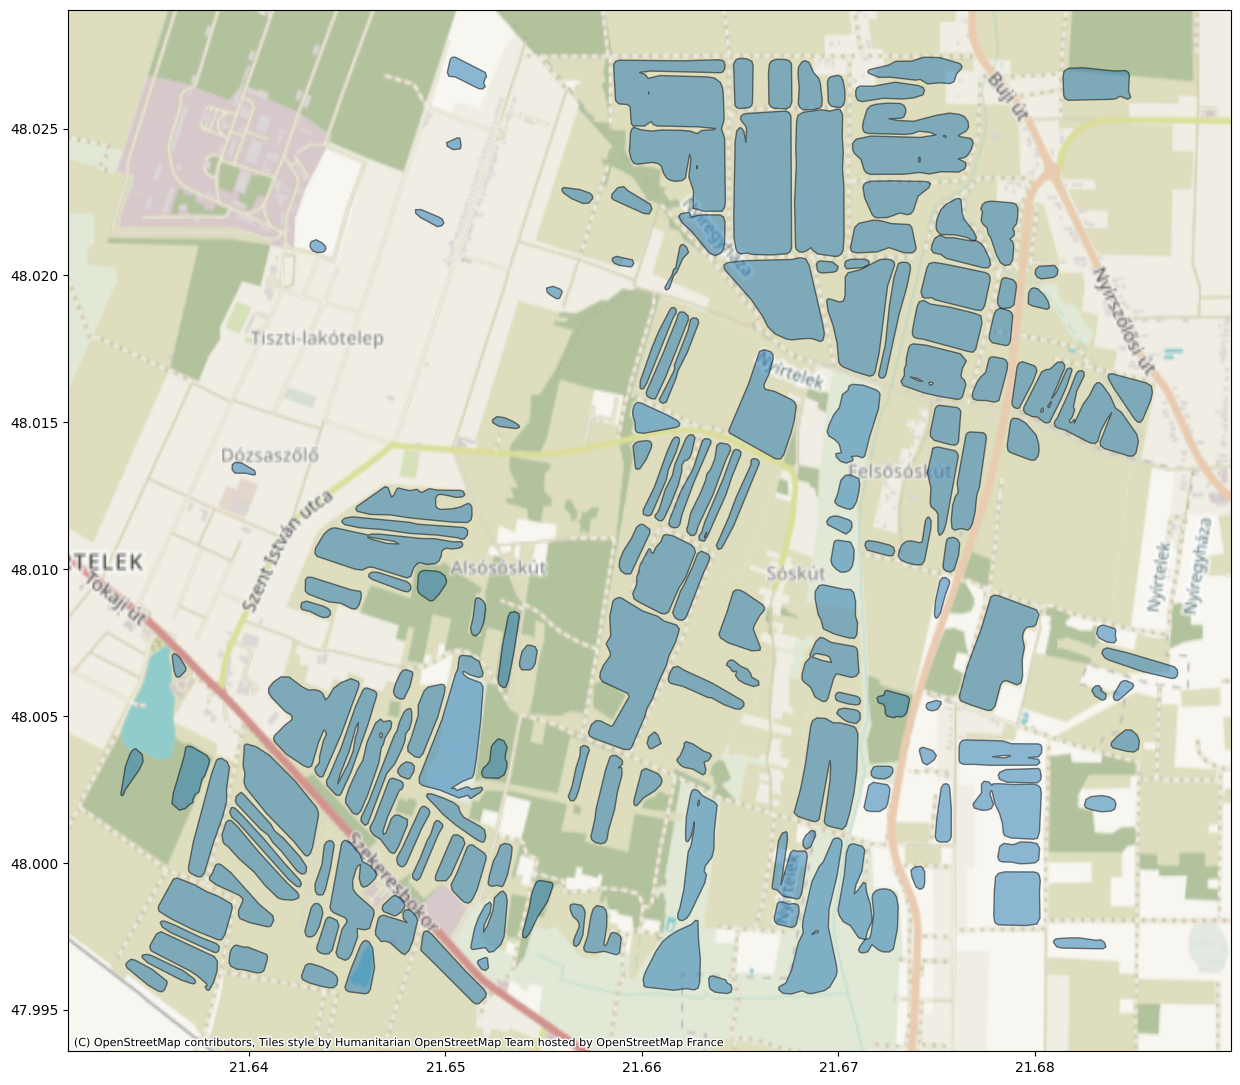

In [12]:
ax = gdf.plot(alpha=0.5, edgecolor="k", figsize = (15,15))
cx.add_basemap(ax, crs=gdf.crs)

In [13]:
# Add the polygons to the map

m1 = folium.Map(location=[(min_lat+max_lat)/2, (min_lon+max_lon)/2], zoom_start=14)

for _, r in gdf.to_crs(4326).iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["area"]).add_to(geo_j)
    geo_j.add_to(m1)

m1

In [14]:
# Filtering many polygons
gdf_filter = gdf.loc[:100]
gdf_filter

,id,area,geometry,determination_datetime,planet:ca_ratio,planet:micd,planet:qa,determination_method,bbox
0,33103797,1.410728,"POLYGON ((21.64534 48.00863, 21.64521 48.00866...",2022-06-01 00:00:00+00:00,2.283350,68.912842,0,auto-imagery,"{'xmin': 21.642864215506396, 'ymin': 48.008634..."
1,33103836,4.367515,"POLYGON ((21.65959 48.00899, 21.65954 48.00916...",2022-06-01 00:00:00+00:00,1.188137,170.421906,0,auto-imagery,"{'xmin': 21.659535542623118, 'ymin': 48.008476..."
2,33103861,0.399203,"POLYGON ((21.64308 48.00857, 21.6427 48.00862,...",2022-06-01 00:00:00+00:00,1.886232,40.514462,0,auto-imagery,"{'xmin': 21.642631946956918, 'ymin': 48.008351..."
3,33103962,0.550601,"POLYGON ((21.65145 48.00773, 21.65134 48.00781...",2022-06-01 00:00:00+00:00,2.049192,43.568317,0,auto-imagery,"{'xmin': 21.651274940417398, 'ymin': 48.007721..."
4,33104053,0.671882,"POLYGON ((21.63351 48.00228, 21.63348 48.00236...",2022-06-01 00:00:00+00:00,3.209024,55.889256,0,auto-imagery,"{'xmin': 21.633483640778774, 'ymin': 48.002284..."
...,...,...,...,...,...,...,...,...,...
96,33133311,1.299675,"POLYGON ((21.65975 48.01465, 21.65966 48.01474...",2022-06-01 00:00:00+00:00,1.445122,95.394447,0,auto-imagery,"{'xmin': 21.659524428070384, 'ymin': 48.014622..."
97,33133422,0.519171,"POLYGON ((21.65974 48.0134, 21.65968 48.01343,...",2022-06-01 00:00:00+00:00,1.134290,61.894398,0,auto-imagery,"{'xmin': 21.65954661555796, 'ymin': 48.0133984..."
98,33133430,1.388173,"POLYGON ((21.6626 48.01012, 21.66283 48.01053,...",2022-06-01 00:00:00+00:00,3.713485,56.272381,0,auto-imagery,"{'xmin': 21.661560622709533, 'ymin': 48.008256..."
99,33133453,0.269154,"POLYGON ((21.64023 48.0132, 21.63986 48.01326,...",2022-06-01 00:00:00+00:00,1.798139,39.465385,0,auto-imagery,"{'xmin': 21.639141842895555, 'ymin': 48.013203..."
